## 《合成孔径雷达成像——算法与实现》中6.3.6 方位压缩


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

from numpy import pi,abs,max,min,argmax,argmin,ceil,exp,sqrt,real,imag,conj,sinc,sin,cos,tan,arctan,log10,angle,unwrap
from numpy import linspace,arange,zeros,ones,concatenate,convolve
from numpy.fft import fft,fftshift,ifft,ifftshift,fft2
from matplotlib.pyplot import figure,subplot,plot,axis,title,suptitle,xlabel,ylabel,text,arrow,tight_layout

In [6]:
## 参数设置
#  已知参数--》距离向参数
R_eta_c = 20e+3;                # 景中心斜距
Tr = 2.5e-6;                    # 发射脉冲时宽
Kr = 20e+12;                    # 距离向调频率
alpha_os_r = 1.2;               # 距离过采样率
# alpha_os_r = 3.4;               # 距离过采样率
Nrg = 320;                      # 距离线采样点数
# Nrg = 512;                      # 距离线采样点数
#  计算参数--》距离向参数
Bw = abs(Kr)*Tr;                # 距离信号带宽
Fr = alpha_os_r*Bw;             # 距离向采样率
Nr = np.round(Fr*Tr);              # 距离采样点数(脉冲序列长度)
#  已知参数--》方位向参数
c = 3e+8;                       # 电磁传播速度
Vr = 150;                       # 等效雷达速度
Vs = Vr;                        # 卫星平台速度
Vg = Vr;                        # 波束扫描速度
f0 = 5.3e+9;                    # 雷达工作频率
Delta_f_dop = 80;               # 多普勒带宽
alpha_os_a = 1.25;              # 方位过采样率
Naz = 256;                      # 距离线数
Naz = 512;                      # 距离线数
theta_r_c = +0.0*pi/180;        # 波束斜视角
#  计算参数--》方位向参数
lambda0 = c/f0;                  # 雷达工作波长
t_eta_c = -R_eta_c*sin(theta_r_c)/Vr;
                                # 波束中心穿越时刻
f_eta_c = 2*Vr*sin(theta_r_c)/lambda0;
                                # 多普勒中心频率
La = 0.886*2*Vs*cos(theta_r_c)/Delta_f_dop;               
                                # 实际天线长度
Fa = alpha_os_a*Delta_f_dop;    # 方位向采样率
Ta = 0.886*lambda0*R_eta_c/(La*Vg*cos(theta_r_c));
                                # 目标照射时间
R0 = R_eta_c*cos(theta_r_c);    # 最短斜距
Ka = 2*Vr**2*cos(theta_r_c)**2/lambda0/R0;# 方位向调频率
theta_bw = 0.886*lambda0/La;     # 方位向3dB波束宽度
theta_syn = Vs/Vg*theta_bw;     # 合成角宽度
Ls = R_eta_c*theta_syn;         # 合成孔径长度
#  参数计算
rho_r = c/(2*Fr);               # 距离向分辨率
rho_a = La/2;                   # 距离向分辨率
Trg = Nrg/Fr;                   # 发射脉冲时宽
Taz = Naz/Fa;                   # 目标照射时间
d_t_tau = 1/Fr;                 # 距离采样时间间隔
d_t_eta = 1/Fa;                 # 方位采样时间间隔
d_f_tau = Fr/Nrg;               # 距离采样频率间隔    
d_f_eta = Fa/Naz;               # 方位采样频率间隔
## 目标设置
#  设置目标点相对于景中心之间的距离
A_r =   0; A_a =   0;                                   # A点位置
B_r = -50; B_a = -50;                                   # B点位置
C_r = -50; C_a = +50;                                   # C点位置
D_r = +50; D_a = C_a + (D_r-C_r)*tan(theta_r_c);        # D点位置
#  得到目标点相对于景中心的位置坐标
A_x = R0 + A_r; A_Y = A_a;                              # A点坐标
B_x = R0 + B_r; B_Y = B_a;                              # B点坐标
C_x = R0 + C_r; C_Y = C_a;                              # C点坐标
D_x = R0 + D_r; D_Y = D_a;                              # D点坐标
NPosition = np.array([[A_x,A_Y],
             [B_x,B_Y],
             [C_x,C_Y],
             [D_x,D_Y]      ])                          # 设置数组
# fprintf( 'A点坐标为[#+3.3f，#+3.3f]km\n', NPosition(1,1)/1e3, NPosition(1,2)/1e3 );
# fprintf( 'B点坐标为[#+3.3f，#+3.3f]km\n', NPosition(2,1)/1e3, NPosition(2,2)/1e3 );
# fprintf( 'C点坐标为[#+3.3f，#+3.3f]km\n', NPosition(3,1)/1e3, NPosition(3,2)/1e3 );
# fprintf( 'D点坐标为[#+3.3f，#+3.3f]km\n', NPosition(4,1)/1e3, NPosition(4,2)/1e3 );
#  得到目标点的波束中心穿越时刻
Ntarget = 4;
Tar_t_eta_c = zeros(Ntarget);
for i in range( Ntarget ):
    DeltaX = NPosition[i][1] - NPosition[i][0]*tan(theta_r_c);
    Tar_t_eta_c[i] = DeltaX/Vs;

#  得到目标点的绝对零多普勒时刻
Tar_t_eta_0 = zeros(Ntarget);
for i in range( Ntarget ):
    Tar_t_eta_0[i] = NPosition[i][1]/Vr;

## 变量设置
#  时间变量 以景中心的零多普勒时刻作为方位向零点
t_tau = arange(-Trg/2,Trg/2,d_t_tau) + 2*R_eta_c/c;   # 距离时间变量
t_eta = arange(-Taz/2,Taz/2,d_t_eta) + t_eta_c;       # 方位时间变量
#  长度变量
r_tau = (t_tau*c/2)*cos(theta_r_c);                     # 距离长度变量
#  频率变量 
f_tau = fftshift(arange(-Fr/2,Fr/2,d_f_tau));           # 距离频率变量
f_tau = f_tau - np.round((f_tau-0)/Fr)*Fr;                 # 距离频率变量(可观测频率)  
f_eta = fftshift(arange(-Fa/2,Fa/2,d_f_eta));           # 方位频率变量
f_eta = f_eta - np.round((f_eta-f_eta_c)/Fa)*Fa;           # 方位频率变量(可观测频率)
## 坐标设置     
#  以距离时间为X轴，方位时间为Y轴
t_tauX,t_etaY = np.meshgrid(t_tau,t_eta);                # 设置距离时域-方位时域二维网络坐标
#  以距离长度为X轴，方位频率为Y轴                                                                                                            
r_tauX,f_etaY = np.meshgrid(r_tau,f_eta);                # 设置距离时域-方位频域二维网络坐标
#  以距离频率为X轴，方位频率为Y轴                                                                                                            
f_tau_X,f_eta_Y = np.meshgrid(f_tau,f_eta);              # 设置频率时域-方位频域二维网络坐标
## 信号设置--》原始回波信号                                                        

In [7]:
from tqdm import trange
bar = trange(Ntarget)
st_tt = zeros((Naz,Nrg),dtype="complex");
import time
for i in bar:
    #  计算目标点的瞬时斜距
    R_eta = sqrt( NPosition[i][0]**2 + Vr**2*(t_etaY-Tar_t_eta_0[i])**2 ); 
    #{
#     R_eta = NPosition[i][0] + Vr**2*t_etaY**2/(2*NPosition[i][0]);   
    #}
    #  后向散射系数幅度
    A0 = ones(4)*exp(+1j*0);   
    #  距离向包络
    wr = np.where(abs(t_tauX-2*R_eta/c) <= Tr/2,1,0);                               
    #  方位向包络
    wa = sinc(0.886*arctan(Vg*(t_etaY-Tar_t_eta_c[i])/NPosition[i][0])/theta_bw)**2;      
    #  接收信号叠加
    st_tt_tar = A0[i]*wr*wa*exp(-1j*4*pi*f0*R_eta/c)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2); 
    #{
#     st_tt_tar = A0[i]*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);
    #}                                                          
    st_tt = st_tt + st_tt_tar;  
    
    time.sleep(0.1);
    bar.set_description( ''+ str( np.round(i/Ntarget*100) ) )
## 绘图

75.0: 100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.27it/s]


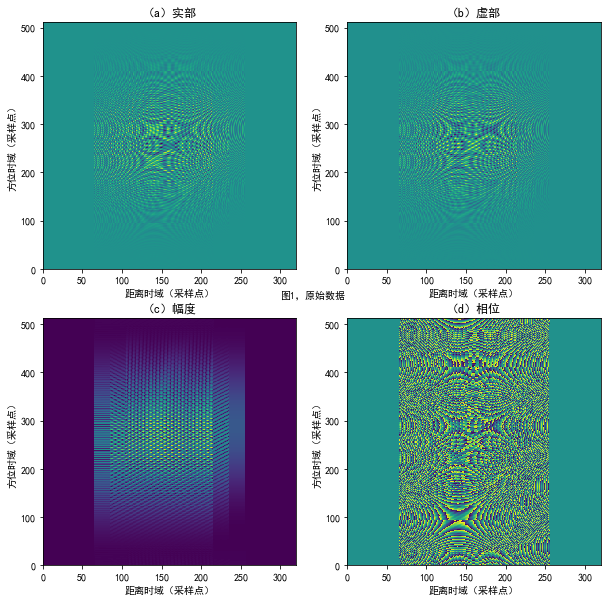

In [8]:
# 作图
# 图1——原始数据
figure(figsize=(10,10))
subplot(2,2,1);
plt.pcolor(real(st_tt))
# plt.colorbar(shrink = 1.0);
title('（a）实部');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');
text(300,-60,'图1，原始数据');       # 给图1进行文字说明 
# text 函数：在图像的指定坐标位置，添加文本框

subplot(2,2,2);
plt.pcolor(imag(st_tt))
# plt.colorbar(shrink = 1.0);
title('（b）虚部');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');

subplot(2,2,3);
plt.pcolor(abs(st_tt))
# plt.colorbar(shrink = 1.0);
title('（c）幅度');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');

subplot(2,2,4);
plt.pcolor(angle(st_tt))
# plt.colorbar(shrink = 1.0);
title('（d）相位');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');


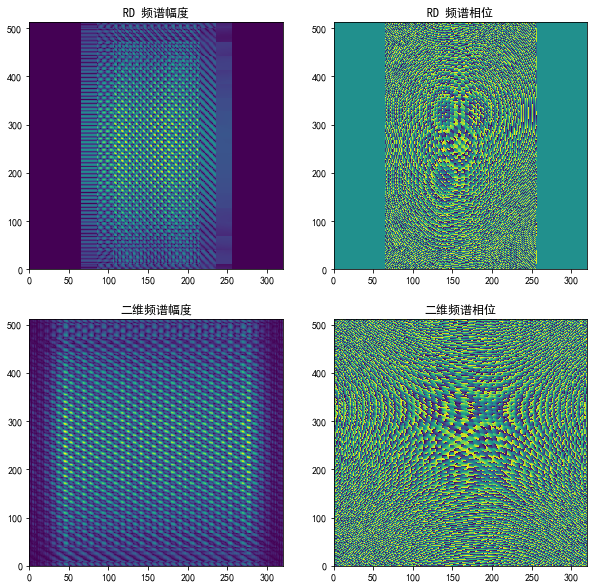

In [10]:
#方向位FFT
Srd = fftshift(fft(fftshift(st_tt),axis=0));
figure(figsize=(10,10));
subplot(2,2,1);
plt.pcolor(abs(Srd))
# plt.colorbar(shrink = 1.0);
title('RD 频谱幅度');
subplot(2,2,2);
plt.pcolor(angle(Srd))
# plt.colorbar(shrink = 1.0);
title('RD 频谱相位');
subplot(2,2,3);
plt.pcolor(abs(fftshift(fft2(fftshift(st_tt)))))
# plt.colorbar(shrink = 1.0);
title('二维频谱幅度');
subplot(2,2,4);
plt.pcolor(angle(fftshift(fft2(fftshift(st_tt)))))
# plt.colorbar(shrink = 1.0);
title('二维频谱相位');

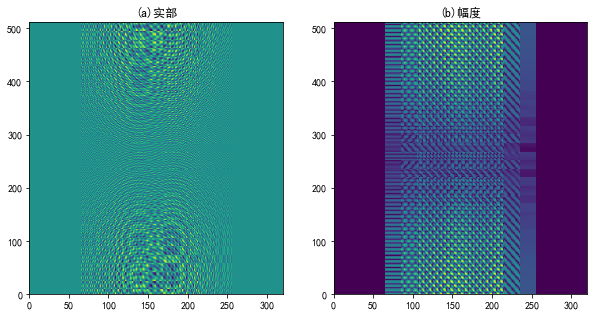

In [67]:
s_rd = st_tt * exp(-1j*2*pi*f_eta_c*(t_eta.reshape((Naz,1))*ones((1,Nrg), dtype="complex")))
S_rd = fft(s_rd, Naz, axis=0 )
figure(figsize=(10,5));
subplot(1,2,1);
plt.pcolor(real(S_rd))
# plt.colorbar(shrink = 1.0);
title('(a)实部');
subplot(1,2,2);
plt.pcolor(abs(S_rd))
# plt.colorbar(shrink = 1.0);
title('(b)幅度');

In [115]:
#  建立变标方程
R_0 = ones((Naz,1), dtype="complex")*R0;
D_f = sqrt(1-c**2*f_eta**2/4/Vr**2/f0**2) #（7.17） 徙动因子
D_feta_Vr = np.matmul(D_f.reshape((Naz,1)),ones((1,Nrg), dtype="complex")); #形成矩阵 Naz * Nrg

In [116]:
aa = (np.matmul(f_eta.reshape((Naz,1)),ones((1,Nrg), dtype="complex")))**2
km_p = 2*Vr**2*f0**3*D_feta_Vr**3/(c*R_0)

In [117]:
Km = Kr/(1-Kr*aa/km_p); # (7.18) 这是变换到距离多普勒域的距离调频率

In [119]:
D_feta_Vrref = np.matmul(D_f.reshape((Naz,1)),ones((1,Nrg), dtype="complex"));
ta_ = np.matmul(t_eta.reshape((Naz,1)),ones((1,Nrg), dtype="complex")) -2*R_eta_c/c/D_feta_Vrref

In [120]:
s_sc = exp(1j*pi*Km*(D_fetaref_Vrref/D_feta_Vrref-1)*ta_**2)


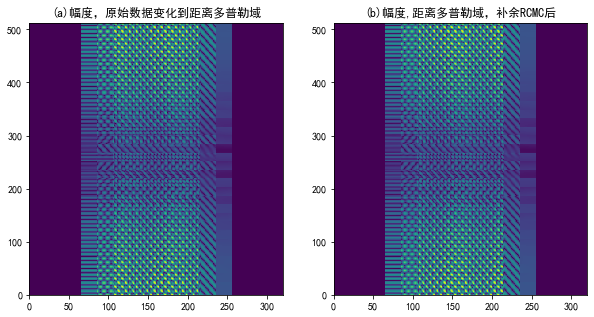

In [121]:
S1 = s_sc*S_rd;
figure(figsize=(10,5));
subplot(1,2,1);
plt.pcolor(abs(S_rd))
# plt.colorbar(shrink = 1.0);
title('(a)幅度，原始数据变化到距离多普勒域');
subplot(1,2,2);
plt.pcolor(abs(S1))
# plt.colorbar(shrink = 1.0);
title('(b)幅度,距离多普勒域，补余RCMC后');

In [122]:
#  距离向FFT，变换到2维频域

S_d = fftshift(fft(fftshift(S1),axis=1))
# S_d = fft(S1,Nrg,axis=1)
# figure(figsize=(10,5));
# subplot(1,2,1);
# plt.pcolor(real(S_d))
# # plt.colorbar(shrink = 1.0);
# title('(a)实部');
# subplot(1,2,2);
# plt.pcolor(abs(S_d))
# # plt.colorbar(shrink = 1.0);
# title('(b)幅度');
# plt.suptitle('变换到二维频域')

In [123]:
# 
s_sc2 = exp(1j*pi*D_feta_Vr/(D_fetaref_Vrref*Km)*f_tau**2)*exp(1j*4*pi/c*(1/D_feta_Vrref-1/D_fetaref_Vrref)*R_eta_c*np.tile(f_tau,(Naz,1)))

S2_d = S_d*fftshift(s_sc2);

# figure(figsize=(10,5));
# subplot(1,2,1);
# plt.pcolor(real(S2_d))
# # plt.colorbar(shrink = 1.0);
# title('(a)实部');
# subplot(1,2,2);
# plt.pcolor(abs(S2_d))
# # plt.colorbar(shrink = 1.0);
# title('(b)幅度');

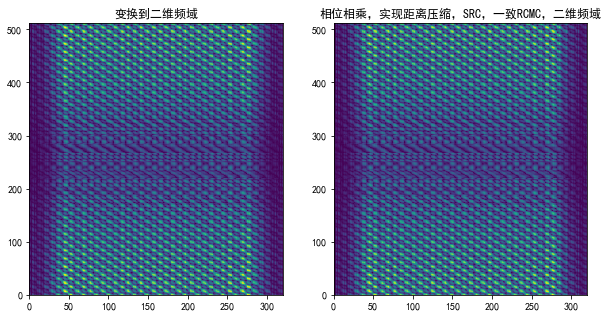

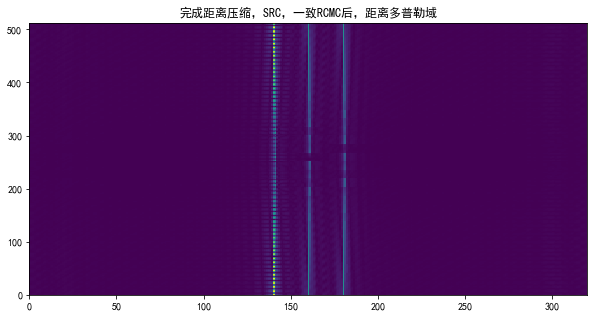

In [124]:
S2 = ifftshift(ifft(ifftshift(S2_d),Nrg,axis=1));
# S2 = ifft(S2_d,Nrg,axis=1);

figure(figsize=(10,5));
subplot(1,2,1);
plt.pcolor(abs(S_d))
# plt.colorbar(shrink = 1.0);
title('变换到二维频域');
subplot(1,2,2);
plt.pcolor(abs(S2_d))
# plt.colorbar(shrink = 1.0);
title('相位相乘，实现距离压缩，SRC，一致RCMC，二维频域');
figure(figsize=(10,5));
plt.pcolor(abs(S2))
# plt.colorbar(shrink = 1.0);
title('完成距离压缩，SRC，一致RCMC后，距离多普勒域');

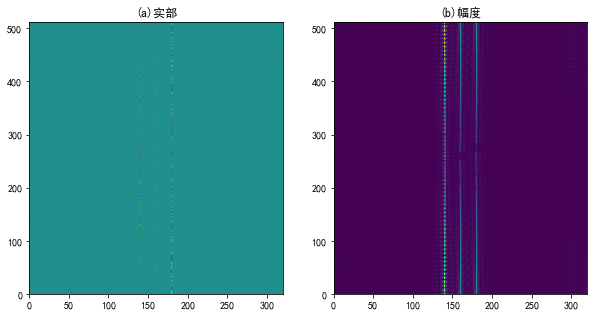

In [125]:
s_sc3 = exp(1j*4*pi*R_0*f0*D_feta_Vr/c)*exp(-1j*4*pi*Km/c**2*(1-D_feta_Vrref/D_fetaref_Vrref)*(R_0/D_feta_Vr-R_eta_c/D_feta_Vr))
S3_rd = S2*s_sc3

figure(figsize=(10,5));
subplot(1,2,1);
plt.pcolor(real(S3_rd))
# plt.colorbar(shrink = 1.0);
title('(a)实部');
subplot(1,2,2);
plt.pcolor(abs(S3_rd))
# plt.colorbar(shrink = 1.0);
title('(b)幅度');

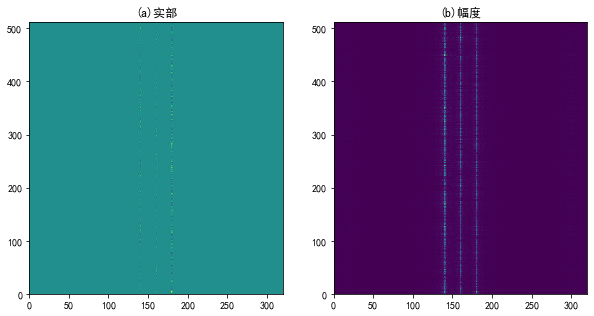

In [128]:
#
S3 = ifftshift(ifft(ifftshift(S3_rd),Naz,axis=0))
# S3 = ifft(S3_rd,Naz,axis=0)
figure(figsize=(10,5));
subplot(1,2,1);
plt.pcolor(real(S3))
# plt.colorbar(shrink = 1.0);
title('(a)实部');
subplot(1,2,2);
plt.pcolor(abs(S3))
# plt.colorbar(shrink = 1.0);
title('(b)幅度');

In [105]:
soutt_tt = S3
# ## 绘图
# H1 = figure(figsize=(10,5));
# # set(H1,'position',[100,100,600,300]); 
# subplot(121),plt.pcolor(real(soutt_tt))
# # plt.colorbar(shrink = 1.0)
# plt.gca().invert_yaxis()

# xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(a)实部')
# subplot(122),plt.pcolor( abs(soutt_tt))
# # plt.colorbar(shrink = 1.0)
# plt.gca().invert_yaxis()

# xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(b)幅度')
# suptitle('图6.12 方位压缩后的仿真结果')

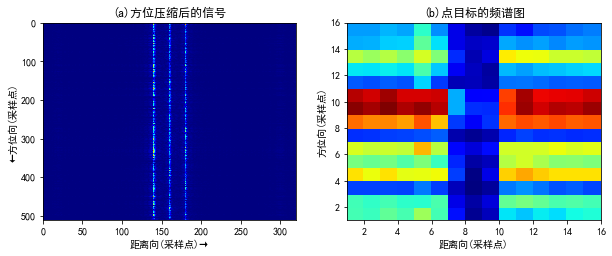

In [106]:

## 信号设置--》点目标分析

len = 16;
cut = arange(-len/2,len/2,1);
kk1 = round(Naz/2 +  NPosition[0,1]/Vr*Fa) + cut
kk2 = round(Nrg/2 +  2*(NPosition[0,0]-R0)/c*Fr) + cut
kk1 = kk1.astype(int)
kk2 = kk2.astype(int)
start_tt = soutt_tt[kk1,:];
start_tt = start_tt[:,kk2]
Start_ff = fft2(start_tt);
## 绘图
H2 = figure(figsize=(10,8)); 
subplot(221),plt.pcolor(abs(soutt_tt),cmap='jet')
plt.gca().invert_yaxis()
# axis([1,Nrg,1,Naz])
xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(a)方位压缩后的信号')
subplot(222),plt.pcolor(abs(Start_ff),cmap='jet')
axis([1,len,1,len])
xlabel('距离向(采样点)');ylabel('方位向(采样点)');title('(b)点目标的频谱图');



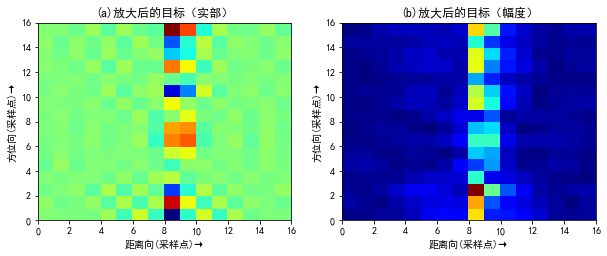

In [107]:
## 绘图
H2 = figure(figsize=(10,8)); 
subplot(221),plt.pcolor(real(start_tt),cmap='jet')
xlabel('距离向(采样点)→'),ylabel('方位向(采样点)→'),title('(a)放大后的目标（实部）')
subplot(222),plt.pcolor(abs(start_tt),cmap='jet')#s
xlabel('距离向(采样点)→');ylabel('方位向(采样点)→');title('(b)放大后的目标（幅度）');


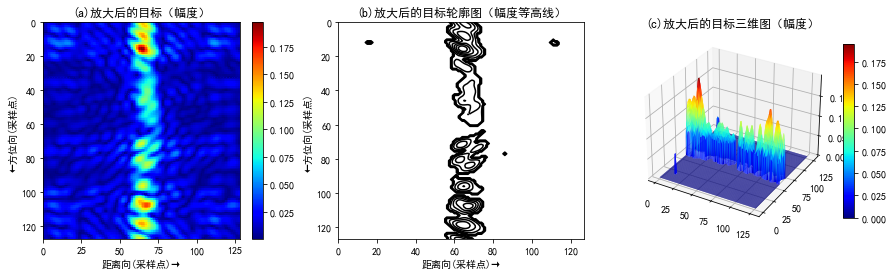

In [108]:
# 下面进行二维升采样
NN = 16
ac_test_1 = fft(start_tt, axis = 0);   # 方位向fft
ac_test_2 = fft(ac_test_1,axis = 1);   # 距离向fft
ac_test_buling_1 = zeros((8*NN,NN),dtype='complex');  # 中间变量
ac_test_buling = zeros((8*NN,8*NN),dtype='complex');
    # 下面先对每列补零，再对每行补零——注意：和上面的先行后列相比，这是有区别的。
for pp in range(NN):          # 在每行的最小值位置补零
    I = argmin(abs(ac_test_2[:,pp]));
    ac_test_buling_1[:I+1,pp] = ac_test_2[:I+1,pp];
    ac_test_buling_1[8*NN-(NN-I)+1:8*NN,pp] = ac_test_2[I+1:NN,pp];

for qq in range(8*NN):         # 在每列的最小值位置补零
    I = argmin(abs(ac_test_buling_1[qq,:]));
    ac_test_buling[qq,:I+1] = ac_test_buling_1[qq,:I+1];
    ac_test_buling[qq,8*NN-(NN-I)+1:8*NN] = ac_test_buling_1[qq,I+1:NN];

ac_test_1 = ifft(ac_test_buling,axis=1);
ac_test = ifft(ac_test_1,axis=0);         # 完成二维升采样。
# 作图
x = range(8*NN);y = range(8*NN)
X,Y = np.meshgrid(x,y)
Z = np.where(abs(ac_test) > 0.05, abs(ac_test), 0)
figure(figsize=(15,4));
subplot(131),plt.pcolor(abs(ac_test),cmap='jet');plt.colorbar()
xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(a)放大后的目标（幅度）')
plt.gca().invert_yaxis()
subplot(132),plt.contour(X,Y,Z,8,colors='k')
xlabel('距离向(采样点)→'),ylabel('←方位向(采样点)'),title('(b)放大后的目标轮廓图（幅度等高线）')
plt.gca().invert_yaxis()
sub = subplot(133,projection='3d')#3d表示三维图像
title('(c)放大后的目标三维图（幅度）')
surf=sub.plot_surface(X,Y,Z[X,Y],rstride=1, cstride=1, cmap='jet', edgecolor='none')
cb=plt.colorbar(surf,shrink=0.8,aspect=15)#添加颜色棒,shrink表示缩放,aspect表示宽



In [109]:
def performance(x,s_number,T):
#
# 针对函数 zhibiao(x,s_number,T) 进行改进，改进的内容主要为：
# 在计算3dB点所对应的坐标时——用来计算 分辨率（IRW）
# 函数 zhibiao() 中采用的是临近取整的办法，这不准确。
# 下面利用的方法是将离 3dB 最近的两个点进行线性插值，来得到更准确的3dB点所对应的坐标。
#
# 输入变量：信号x，采样点数 s_number，T是信号的时域长度。
# 该函数用来求解 x 的峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
    soo = x;                # 信号x
    N_buling = s_number;    # 采样点数

    soo_abs = abs(soo);     # soo的模
    I = argmax(soo_abs);   # 求输出 soo的模 中的最大值 C，位置 I；
    C = soo_abs[I]
    y = soo_abs**2;         # 输出的平方， y = soo^2。

    x1 = 0;
    while (soo_abs[I-x1-1]-soo_abs[I-x1])<0:
        M1 = x1;
        x1 = x1+1;
    x2 = 0;
    while (soo_abs[I+x2+1]-soo_abs[I+x2])<0:
        M2 = x2;
        x2 = x2+1;


    P1 = I-1-M1;            # 主瓣和旁瓣分界点，左边的坐标是 P1。
    P2 = I+1+M2;            # 主瓣和旁瓣分界点，右边的左边是 P2。

    D_left = max(soo_abs[:P1]);     # 最大旁瓣，值为 D_left，位置为 Q_left。（左边的那一个）。
                                  
    D_right = max(soo_abs[P2:]); # 最大旁瓣，值为 D_right，位置为 Q_right。（右边的那一个）。
    D = max([D_left,D_right]);    # 比较左边和右边两者中的最大值，得到两侧旁瓣中最大的旁瓣，值为 D。

    PSLR = 20*log10(D/C);                       # 峰值旁瓣比
    ISLR = 10*log10((sum(y[int(P1/20):P1])+sum(y[P2:]))/sum(y[P1:P2]));# 积分旁瓣比。

    #######################  以下是求 IRW  #########################
    M = ( 10**(-3/20) )*C;       # 3dB 带宽处的函数取值。
    # 下面是为了求找出与该函数值最接近的值的大小和坐标。
    z1 = abs(soo_abs[P1]-M);
    x1 = 0;
    z1_x1 = 0;
    for k1 in range(P1,I+1,1):
        cha1 = abs(soo_abs[P1+x1]-M);
        if cha1<z1:
            z1 = cha1;
            z1_x1 = x1; # z1_x1 是我们需要的，它的值是所求坐标与 P1 的偏移量。（左侧的）
        x1 = x1+1;


    z2 = abs(soo_abs[I]-M);
    x2 =0;
    z2_x2 = 0;
    for k2 in range(I,P2+1,1):
        cha2 = abs(soo_abs[I+x2]-M);
        if cha2<z2:
            z2 = cha2;
            z2_x2 = x2;# z2_x2 是我们需要的，它的值是所求坐标与 I 的偏移量。（右侧的）
        x2 = x2+1;
  

    Th_x1 = P1+z1_x1;# Th_x1 就是我们所求3dB带宽点左侧那个点的坐标（距离3dB最近的整数点）
    Th_x2 = I+z2_x2; # Th_x2 就是····3dB带宽点右侧······（距离3dB最近的整数点）
    # ------------------------------------------------------------------
    # 通过上面求得的距离3dB最近的整数点 Th_x1 和 Th_x2
    # 利用线性插值，得到3dB带宽所对应点数的更准确的值
    # 计算左边3dB的那个坐标
    if soo_abs[Th_x1]-M < 0:
        x0_linear = Th_x1;
        x1_linear = Th_x1+1;
    else:
        x0_linear = Th_x1-1;
        x1_linear = Th_x1;
 
    Th_x1_real = (M-soo_abs[x1_linear])/(soo_abs[x0_linear]-soo_abs[x1_linear])*x0_linear + (M-soo_abs[x0_linear])/(soo_abs[x1_linear]-soo_abs[x0_linear])*x1_linear;

    # 计算右边3dB的那个坐标
    if soo_abs[Th_x2]-M > 0:
        x0_linear = Th_x2;
        x1_linear = Th_x2+1;
    else:
        x0_linear = Th_x2-1;
        x1_linear = Th_x2;

    Th_x2_real = (M-soo_abs[x1_linear])/(soo_abs[x0_linear]-soo_abs[x1_linear])*x0_linear  + (M-soo_abs[x0_linear])/(soo_abs[x1_linear]-soo_abs[x0_linear])*x1_linear;
    # ------------------------------------------------------------------
    width = Th_x2_real-Th_x1_real;  # width 就是通过此种方法求得的 3dB带宽。

    c = 3e8;# 光速 c=3e8 m/s。
    IRW = T/N_buling*width*c/2;# 注意在SAR中，分辨率是 C*T/2,其中T是脉冲宽度。
    # IRW_real为图像分辨率，原来的width的单位是采样间隔。一般图像分辨率单位取 m，要转换。
    # 注意到采样点数用的是 N_buling，因为频域补零后等效为升采样，采样率提高，采样点数应该跟正为 N_buling。
    return PSLR,ISLR,IRW

In [110]:
# function [PSLR_r,ISLR_r,IRW_r, PSLR_a,ISLR_a,IRW_a] = target_analysis_2(s_ac,Fr,Fa,Vr)
# !pip install scikit-image
# from skimage.transform import rotate as imrotate
from scipy.ndimage import rotate
def target_analysis_2(s_ac,Fr,Fa,Vr):
# 截止到 2014.10.10 10:34 a.m.
# 
# 2014.10.10. 修改了： 指标计算函数采用更改后的: zhibiao_2( )
# 2014.10.10. 修改了： 二维补零方式更改为第 2 种方法：先对每列补零，再对每行补零。
#
# ===============================================================
# 该程序考虑了大斜视角下，对点目标的扭曲
# 分别考虑距离向和方位向
# 考虑距离向旋转角度，将距离向轴旋转到平行于水平轴，再取出行切片
# 考虑方位向旋转角度，将方位向轴旋转到平行于垂直轴，再取出列切片
# ===============================================================
#
# 输入变量： s_ac  ——是需要进行指标分析的点目标点k，s_ac是它所在的一块矩阵数据。
# 输入变量： Fr  —— 距离向采样率
# 输入变量： Fa  —— 方位向采样率
# 输入变量： Vr  —— 平台速度
# 该函数用来求解点目标k的各项指标
# 点目标中心的行切片（距离向）：峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
# 点目标中心的列切片（方位向）：峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
# 输出值分别是行切片和列切片的各项指标
#
# 补零方式很关键
# 这里采用的方法是逐行，逐列判断数据最小值位置，然后将在最小值位置处进行补零
#
########################################################
#       取点目标中心 NN*NN 切片，进行升采样
#   再取点目标中心，距离向切片，方位向切片，进行升采样
#                   计算各项性能指标
########################################################

    c = 3e8;                # 光速
    NN = 32;        # 切片总长度，NN*NN
    row,column = s_ac.shape;      # s_ac的矩阵大小
    p = argmax(abs(s_ac),axis=1); 
    v = max(abs(s_ac),axis=1);
    q = argmax(v);

    row_max    = p[q];      # 二维矩阵最大值，所在第几行—— row_max。
    column_max = q;         # 二维矩阵最大值，所在第几列—— column_max。
    s_ac_max   = v[q];      # 矩阵最大值是—— x_max。
    hNN = int(NN/2)
    rstart = max([row_max-hNN,0])
    rend   = min([row_max+hNN,row])
#     if( rend-rstart>=NN ): 
    rend = rstart+NN
    cstart = max([column_max-hNN,0])
    cend   = min([column_max+hNN,column])
#     if( cend-cstart>=NN ): 
    cend   = cstart+NN
    s_ac_test = s_ac[rstart:rend,cstart:cend];
    # 得到NN*NN的切片

    # 下面进行二维升采样
    S_ac_test_1 = fft(s_ac_test,  axis = 0);   # 方位向fft
    S_ac_test_2 = fft(S_ac_test_1,axis = 1);   # 距离向fft

    # 接下来进行二维补零
    # =========================================================================
    # 利用两个for循环，在每行和每列最小值的位置处补上7*NN的零，实现高频补零。
    #------------------------------------------------------------------
    #{
    # 第 1 种方法： 先对每行补零，再对每列补零。
#     S_ac_test_buling_1 = zeros((NN,8*NN),dtype='complex');  # 中间变量
#     S_ac_test_buling = zeros((8*NN,8*NN),dtype='complex');
#     # 下面先对每行补零，再对每列补零
#     for pp in range(NN):           # 在每行的最小值位置补零
#         I = argmin(abs(S_ac_test_2[pp,:]));
#         S_ac_test_buling_1[pp,:I+1] = S_ac_test_2[pp,:I+1];
#         S_ac_test_buling_1[pp,8*NN-(NN-I)+1:8*NN] = S_ac_test_2[pp,I+1:NN];

    # for qq = 1:8*NN         # 在每列的最小值位置补零
    #     [C,I] = min(S_ac_test_buling_1(:,qq));
    #     S_ac_test_buling(1:I,qq) = S_ac_test_buling_1(1:I,qq);
    #     S_ac_test_buling(8*NN-(NN-I)+1:8*NN,qq) = S_ac_test_buling_1(I+1:NN,qq);
    # end
    # 由于上面的在每列的最小值位置补零，得到的结果是有问题的，因此下面进行修改
    # 修改方法是：
    #       直接对每一列，在中间补零
#     NN2 = int(NN/2)
#     S_ac_test_buling[:NN2,:] = S_ac_test_buling_1[:NN2,:];
#     S_ac_test_buling[8*NN-NN2:8*NN,:] = S_ac_test_buling_1[NN2:NN,:];
#     np.savetxt('S_ac_test_buling.txt',S_ac_test_buling)
    #}
    #------------------------------------------------------------------
    #
    # 第 2 种方法： 先对每列补零，再对每行补零。
    S_ac_test_buling_1 = zeros((8*NN,NN),dtype='complex');  # 中间变量
    S_ac_test_buling = zeros((8*NN,8*NN),dtype='complex');
    # 下面先对每列补零，再对每行补零——注意：和上面的先行后列相比，这是有区别的。
    for pp in range(NN):          # 在每行的最小值位置补零
        I = argmin(abs(S_ac_test_2[:,pp]));
        S_ac_test_buling_1[:I+1,pp] = S_ac_test_2[:I+1,pp];
        S_ac_test_buling_1[8*NN-(NN-I)+1:8*NN,pp] = S_ac_test_2[I+1:NN,pp];

    for qq in range(8*NN):         # 在每列的最小值位置补零
        I = argmin(abs(S_ac_test_buling_1[qq,:]));
        S_ac_test_buling[qq,:I+1] = S_ac_test_buling_1[qq,:I+1];
        S_ac_test_buling[qq,8*NN-(NN-I)+1:8*NN] = S_ac_test_buling_1[qq,I+1:NN];
    #}
    #------------------------------------------------------------------
    # =========================================================================
    S_ac_test_1 = ifft(S_ac_test_buling,axis=1);
    s_ac_test = ifft(S_ac_test_1,axis=0);         # 完成二维升采样。
    # 作图
    figure(figsize=(10,8));
    plt.pcolor(abs(s_ac_test));
    title('将成像结果做升采样，看效果如何');

    ## 
    # 下面分别对点目标中心（二维最大值）做行切片，和列切片。
    # 每一个切片，都做 16倍 升采样。
    # 并分别作出归一化的对数幅度图。
    # -------------------------------------------------------
    # 考虑图像扭曲
    # 将目标进行旋转和扭曲，以使大部分旁瓣对齐至水平轴和垂直轴
    # -------------------------------------------------------

    ## 
    # 取出行切片

    # 第一步，找出升采样后点目标中心的位置和大小
    row_test,column_test = s_ac_test.shape;      # s_ac_test的矩阵大小
    p_test = argmax(abs(s_ac_test),axis=0);
    v_test = max(abs(s_ac_test),axis=0);
    q_test = argmax(v_test);

    row_test_max = p_test[q_test];      # 二维矩阵最大值，所在第几行—— row_max。
    column_test_max = q_test;           # 二维矩阵最大值，所在第几列—— column_max。
    s_ac_test_max = v_test[q_test];            # 矩阵最大值是—— x_max。
    # 第二步，找出点目标中心左侧2/3长度内的最大值，以此来计算距离旁瓣的扭曲角度
    # 注意到，如果直接在左侧2/3长度内寻找最大值，有可能会误判到方位旁瓣上的点；
    # 因此，由于斜视角的关系，左侧的距离旁瓣一定是向上倾斜的；
    # 因此下面的寻找中，行直接规定为在点目标中心所在行的上方。
    c3 = int(2*(column_test_max+1)/3)
    p_test_2 = argmax(abs(s_ac_test[:row_test_max+1,:c3]),axis=0);  
    v_test_2 = max(abs(s_ac_test[:row_test_max+1,:c3]),axis=0);
    q_test_2 = argmax(v_test_2);
    row_test_max_2 = p_test_2[q_test_2];  # 二维矩阵点目标中心左侧2/3长度的最大值，所在第几行
    column_test_max_2 = q_test_2;# 二维矩阵点目标中心左侧2/3长度的最大值，所在第几列
    
    # 第三步，计算距离旁瓣扭曲的转角
    range_theta = arctan( abs((row_test_max_2-row_test_max)/(column_test_max_2-column_test_max)) );
    
    # 结果是弧度，下面转成角度
    range_theta = range_theta/pi*180;   # 这是距离旁瓣扭曲的角度
#     print( 'range_theta:',range_theta )
    # 第四步，将升采样的结果s_ac_test以角range_theta进行旋转（这里是逆时针旋转）
    s_ac_range = rotate(s_ac_test,range_theta);# 采用'bilinear'，双线性插值的方式
    # s_ac_range是旋转后的图像
    # 距离向切片就以此来计算。

    # 作图
    figure(figsize=(10,8));
    plt.pcolor(abs(s_ac_range));
    title('将距离向旁瓣旋转到平行于水平轴后的成像结果');

    # 第五步，找出旋转后的最大值中心，并取出相应的行切片
    p_test_range = argmax(abs(s_ac_range),axis=0);    
    v_test_range = max(abs(s_ac_range),axis=0);  
    q_test_range = argmax(v_test_range);
    row_test_max_range = p_test_range[q_test_range]; # 旋转后，点目标中心，所在第几行
    column_test_max_range = q_test_range;  # 旋转后，点目标中心，所在第几列

    cm3 = int((column_test_max_range+1)/3)
    s_ac_test_row_max = s_ac_range[row_test_max_range,cm3:5*cm3];
    # s_ac_test_row_max是取出的点目标中心行切片。
    # 其中，这里并没有把s_ac_range的一行全部取出来，而是将最左右两侧的一部分去除了。

    # 下面进行16倍升采样
    S_AC_test_row_max_1 = fft(s_ac_test_row_max);   # 变换到频域
    slen = S_AC_test_row_max_1.size
    slen2 = int(slen/2)
    # -----------------------------------------------------------------------
    # 以下分别是两种补零方式：
    # 方式 1 ：在高频（中间）补零
    S_AC_test_row_max = concatenate((S_AC_test_row_max_1[:slen2],zeros(15*slen,dtype='complex'),S_AC_test_row_max_1[slen2:]));

    # 方式 2 ：在最小值处补15倍的零
    # S_AC_test_row_max = zeros(1,16*length(S_AC_test_row_max_1));
    # [C1,I1] = min(S_AC_test_row_max_1);
    # S_AC_test_row_max(1,1:I1) = S_AC_test_row_max_1(1,1:I1);
    # S_AC_test_row_max(1,16*length(S_AC_test_row_max_1)+1-(length(S_AC_test_row_max_1)-I1):end) = S_AC_test_row_max_1(1,I1+1:end);
    # ------------------------------------------------------------------------- 
    # 到这里为止，频域补零完成    
    s_ac_test_row_max = ifft(S_AC_test_row_max);  # 进行IFFT，回到时域，得到升采样过后的行切片。
    # 到这里为止，升采样完成

    # 下面做归一化的对数幅度图
    s_ac_test_row_max_abs = abs(s_ac_test_row_max);             # 取幅度
    s_ac_test_row_max_abs = 20*log10(s_ac_test_row_max_abs);    # 取对数
    s_ac_test_row_max_abs = s_ac_test_row_max_abs - max(s_ac_test_row_max_abs); # 归一化

    # 作图
    figure(figsize=(20,8));
    subplot(121),plot(s_ac_test_row_max_abs);
    title('点目标中心（幅值）')
    subplot(122),plot(angle(s_ac_test_row_max));
    title('点目标中心（相位）')
    suptitle('点目标中心，行切片');
#     figure(figsize=(20,10));
#     plot(s_ac_test_column_max_abs);
#     title('点目标中心，列切片');


    ##
    # 取出列切片

    # 第一步，找出升采样后点目标中心的位置和大小
    # （这和取出行切片时相同）

    # 第二步，找出点目标中心上方（方位向）2/3长度内的最大值，以此来计算方位旁瓣的扭曲角度
    # 注意到，如果直接在上方2/3长度内寻找最大值，由于距离旁瓣较强，所以有可能会误判到距离旁瓣上的点；
    # 因此，由于斜视角的关系，上方的方位旁瓣一定是向右倾斜的；
    # 因此下面的寻找中，列直接规定为在点目标中心所在列的右侧。
    cm3 = int(2*row_test_max/3)
    p_test_3 = argmax(abs(s_ac_test[:cm3,column_test_max:-10]),axis=0); 
    v_test_3 = max(abs(s_ac_test[:cm3,column_test_max:-10]),axis=0);  
    q_test_3 = argmax(v_test_3);

    row_test_max_3 = p_test_3[q_test_3];  # 二维矩阵点目标中心上方2/3长度的最大值，所在第几行
    column_test_max_3 = q_test_3;# 二维矩阵点目标中心上方2/3长度的最大值，所在第几列，这里要注意！！
    # 注意：column_test_max_3 由于是直接在点目标中心所在列的右侧进行判断的，因此这里的值是相对于点目标中心所在列的相对值。

    # 第三步，计算方位旁瓣扭曲的转角
    azimuth_theta = arctan( abs((column_test_max_3)/(row_test_max_3-row_test_max)) );
    # 结果是弧度，下面转成角度
    azimuth_theta = azimuth_theta/pi*180;   # 这是方位旁瓣扭曲的角度
    # 第四步，将升采样的结果s_ac_test以角azimitu_theta进行旋转（这里是逆时针旋转）
    s_ac_azimuth = rotate(s_ac_test,azimuth_theta);# 采用'bilinear'，双线性插值的方式
    # s_ac_azimuth是旋转后的图像
    # 方位向切片就以此来计算。

    # 作图
    figure(figsize=(10,8));
    plt.pcolor(abs(s_ac_azimuth));
    title('将方位向旁瓣旋转到平行于垂直轴后的成像结果');

    # 第五步，找出旋转后的最大值中心，并取出相应的列切片
    p_test_azimuth = argmax(abs(s_ac_azimuth),axis=0);
    v_test_azimuth = max(abs(s_ac_azimuth),axis=0);
    q_test_azimuth = argmax(v_test_azimuth);
    row_test_max_azimuth = p_test_azimuth[q_test_azimuth]; # 旋转后，点目标中心，所在第几行
    column_test_max_azimuth = q_test_azimuth;  # 旋转后，点目标中心，所在第几列。
    cm3 = int((row_test_max_azimuth+1)/3)
    cm5 = int(5*(row_test_max_azimuth+1)/3)

    s_ac_test_column_max = s_ac_azimuth[cm3:cm5,column_test_max_azimuth];
#     s_ac_test_column_max = s_ac_azimuth[:,column_test_max_azimuth];
    # s_ac_test_column_max是取出的点目标中心列切片。
    # 其中，这里并没有把s_ac_azimuth的一列全部取出来，而是将最上下两侧的一部分去除了。
#     s_ac_test_column_max = s_ac_test_column_max.';  # 转为行向量，便于统一处理
    # 下面进行16倍升采样
    S_AC_test_column_max_1 = fft(s_ac_test_column_max);
    slen = S_AC_test_column_max_1.size
    # 在最小值处补15倍的零
    S_AC_test_column_max = zeros(16*slen,dtype='complex');
    I2 = argmin(abs(S_AC_test_column_max_1));
    S_AC_test_column_max[:I2+1] = S_AC_test_column_max_1[:I2+1];
    S_AC_test_column_max[16*slen+1-(slen-I2):] = S_AC_test_column_max_1[I2+1:];
    s_ac_test_column_max = ifft(S_AC_test_column_max);    	# 升采样过后的列切片。
    # 完成16倍升采样   

    # 下面做归一化的对数幅度图
    s_ac_test_column_max_abs = abs(s_ac_test_column_max);           # 取幅度   
    s_ac_test_column_max_abs = 20*log10(s_ac_test_column_max_abs);  # 取对数
    s_ac_test_column_max_abs = s_ac_test_column_max_abs - max(s_ac_test_column_max_abs);# 归一化

    # 作图
    figure(figsize=(20,8));
    subplot(121),plot(s_ac_test_column_max_abs);title('点目标中心（幅值）')
    subplot(122),plot(angle(s_ac_test_column_max));title('点目标中心（相位）')
    suptitle('点目标中心，列切片');

    ##
    # 行切片，点目标中心距离向指标
    PSLR_r,ISLR_r,IRW_r = performance(s_ac_test_row_max,16*8*NN,NN/Fr);
    parameter_r = [PSLR_r,ISLR_r,IRW_r];

    # 列切片，点目标中心方位向指标
    PSLR_a,ISLR_a,IRW_a = performance(s_ac_test_column_max,16*8*NN,NN/Fa);
    IRW_a = (IRW_a/c*2)*Vr;
    parameter_a = [PSLR_a,ISLR_a,IRW_a];

    print('------------------------------------------------------');
    print('行切片，点目标中心距离向指标');
    print('      PSLR     ISLR       IRW');
    print(parameter_r);
    print('------------------------------------------------------');
    print('列切片，点目标中心方位向指标');
    print('      PSLR     ISLR       IRW');
    print(parameter_a);
    print('------------------------------------------------------');

    return PSLR_r,ISLR_r,IRW_r, PSLR_a,ISLR_a,IRW_a

ValueError: attempt to get argmax of an empty sequence

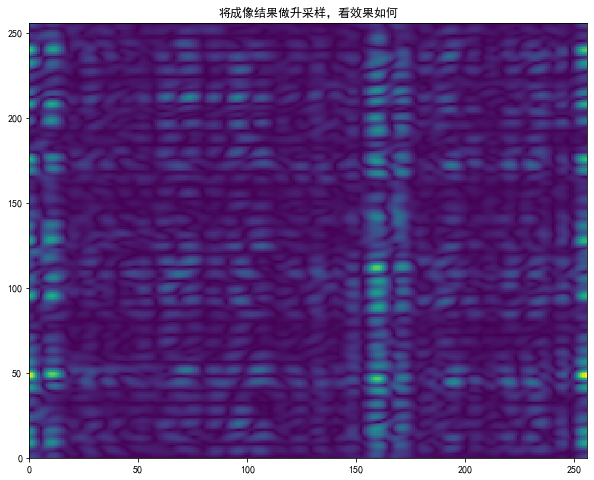

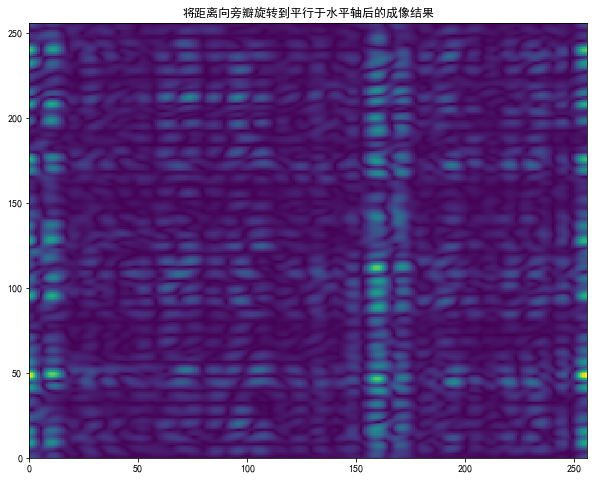

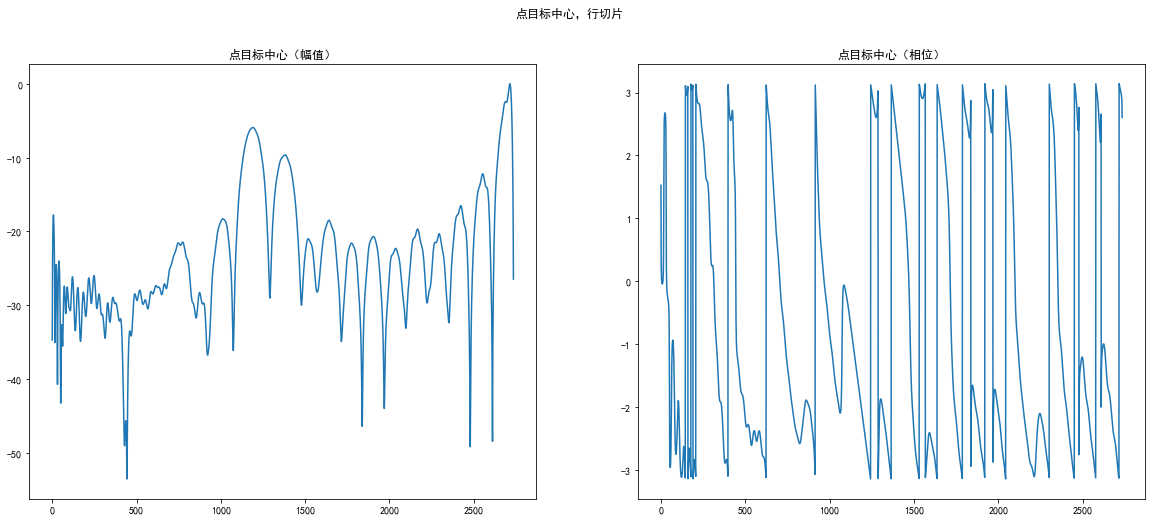

In [111]:
NN = 40;
# 分别得到每个点目标的切片放大；行切片、列切片；和相应的指标
# 目标1，点目标中心在 （ tg_1_x，tg_1_y ）
len = NN;
cut = arange(-len/2,len/2,1);
kk1 = round(Naz/2 +  NPosition[0,1]/Vr*Fa) + cut
kk2 = round(Nrg/2 +  2*(NPosition[0,0]-R0)/c*Fr) + cut
kk1 = kk1.astype(int)
kk2 = kk2.astype(int)
# print( kk1,kk2)
start_tt = soutt_tt[kk1,:];
start_tt = start_tt[:,kk2]

target_area = start_tt
target_analysis_2( target_area,Fr,Fa,Vr);

本文Python代码参照Matlab代码自：https://github.com/wanghs008/SAR-SignalProcessing